In [2]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, medfilt
from scipy.ndimage.filters import percentile_filter

parula_colors = np.load('/Users/arcticfox/parula_colors.npy')

In [3]:
def group_inds(values):
    results = []

    for i, v in enumerate(values):
        if i == 0:
            mini = maxi = v
            temp = [v]
        else:
            # SETS 4 CADENCE LIMIT                                                                                                                                                        
            if (np.abs(v-maxi) <= 50):
                temp.append(v)
                if v > maxi:
                    maxi = v
                if v < mini:
                    mini = v
            else:
                results.append(temp)
                mini = maxi = v
                temp = [v]

            # GETS THE LAST GROUP                                                                                                                                                         
            if i == len(values)-1:
                results.append(temp)

    return np.array(results)

In [4]:
def get_offsets(w1, s1, w2, s2, peaks):
    
    p1, _ = find_peaks(-s1, peaks[0])
    plt.plot(w1, -s1, 'k')
    g1 = group_inds(p1)
    
    fg1 = np.zeros(len(g1), dtype=int)
    for i in range(len(g1)):
        x = np.argmin(s1[g1[i]])
        fg1[i] = g1[i][x]
    
    p2, _ = find_peaks(-s2, peaks[1])
    plt.plot(w2, -s2, 'deepskyblue')
    g2 = group_inds(p2)
    
    fg2 = np.zeros(len(g2), dtype=int)
    for i in range(len(g2)):
        x = np.argmin(s2[g2[i]])
        fg2[i] = g2[i][x]
    
    offsets = np.zeros(len(fg1))
    wavecor = np.zeros(len(fg1))

    for i in range(len(fg1)):
        m1, m2 = int(np.nanmedian(fg1[i])), int(np.nanmedian(fg2[i]))
        diff1 = w1[m1]
        diff2 = w2[m2]
        offsets[i] = diff2 - diff1
        wavecor[i] = diff1 + 0.0
        
        plt.plot(w1[m1], -s1[m1], 'wo')
        plt.plot(w2[m2], -s2[m2], 'ko')
        
    print(wavecor, offsets)
    print(len(fg1), len(fg2))
    plt.show()
        
    o_interp = interp1d(wavecor, offsets)
    
    plt.plot(wavecor, offsets)
    q = ((w1>=wavecor[0]) & (w1<=wavecor[-1]))
    plt.plot(w1[q], o_interp(w1[q]))

    return o_interp(w1[q]), q, wavecor, offsets

## Our data

In [92]:
datadir = '/Users/arcticfox/Downloads/gemini_data'
specfile = np.load(os.path.join(datadir, 'corrected_spectra.npy'))
wavefile = np.load(os.path.join(datadir, 'corrected_wavelengths.npy'))
ofile = np.load(os.path.join(datadir, 'corrected_orders.npy'))
efile = np.load(os.path.join(datadir, 'corrected_errors.npy'))

datadir = '/Users/arcticfox/Downloads/gemini_data'

lines = Table.read(datadir + '_2021/fraunhofer.txt', format='ascii')
lines.add_row(['HeI', 587.5618, 587.5618, 16])

In [93]:
wavedict = {}
specdict = {}
stddict = {}
for i in range(len(lines)):
    wdat = wavefile[:,lines['index'][i]]
    sdat = specfile[:,lines['index'][i]]
    edat = efile[:,lines['index'][i]]
    wavedict[lines['line'][i]] = wdat
    specdict[lines['line'][i]] = sdat
    stddict[lines['line'][i]] = edat
    
cutends = {}
cutends['halpha_temp'] = [600, -240]
cutends['halpha_ours'] = [372, -400]
#spectra = np.load('interp_1d_spectra.npy')

## Opera Data

In [94]:
datadir = '/Users/arcticfox/Documents/atmospheres/v1298tau/data'
files = np.sort([os.path.join(datadir, i) for i in os.listdir(datadir) 
                 if i.endswith('m.fits')])

In [95]:
i = 0
for i in range(len(files)):
    hdu = fits.open(files[i])
    
    if i == 0:
        wavelengths = np.zeros((len(files), len(hdu[0].data[0])))
        spectra = np.zeros(wavelengths.shape)
        errors = np.zeros(wavelengths.shape)
        orders = np.zeros(wavelengths.shape)
        
    try:
        wavelengths[i] = hdu[0].data[4]+0.0
        spectra[i] = hdu[0].data[10]
        errors[i] = hdu[0].data[11]
        orders[i] = hdu[0].data[0]
        
    except ValueError:
        diff = len(hdu[0].data[0]) - wavelengths.shape[1]
        cutends = int(diff/2.0)
        wavelengths[i] = hdu[0].data[4][cutends:-cutends]
        spectra[i] = hdu[0].data[10][cutends:-cutends]
        errors[i] = hdu[0].data[11][cutends:-cutends]
        orders[i] = hdu[0].data[0][cutends:-cutends]

In [96]:
unique_orders = np.unique(orders[0])
flattened_spectra = np.zeros(spectra.shape)

for i in range(len(spectra)):
    flat = np.zeros(len(spectra[i]))
    for u in unique_orders:
        q = orders[i]==u

        fit = percentile_filter(spectra[i][q], percentile=90, size=450)
        flat[q] = spectra[i][q]/fit
    flattened_spectra[i] = flat

In [97]:
def single_out(order, lowlim=0, upplim=0, repeat=1, plot=True):

    z = 0
    for i in range(len(files)):
        q = ((orders[i] == order))# & (wavelengths[i]>=lowlim) & (wavelengths[i]<=upplim))

        if i == 0:
            wgrid = np.zeros((len(files)*repeat, len(flattened_spectra[i][q])))
            grid = np.zeros((len(files)*repeat, len(flattened_spectra[i][q])))
            

        if plot:
            plt.plot(wavelengths[i][q], flattened_spectra[i][q], c=parula_colors[i*4])
            
        try:
            grid[z:z+repeat] = flattened_spectra[i][q]
            wgrid[z:z+repeat] = wavelengths[i][q]
        except:
            grid[z:z+repeat] = flattened_spectra[i][q][1:]
            wgrid[z:z+repeat] = wavelengths[i][q][1:]
        z+=repeat
    
    if plot:
        plt.show()
    inds = np.append(np.arange(0,5,1,dtype=int),
                     np.arange(len(files)-5,len(files),1,dtype=int))
    template = np.nanmedian(grid, axis=0)
    return wgrid, grid, template

HeI


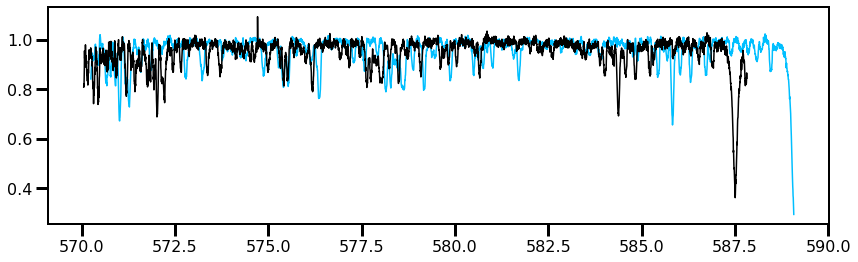

In [98]:
index = 16+23
key = lines[lines['index']+23==index]['line'][0]
print(key)
wgrid, grid, temp = single_out(index, plot=False)#, 635.0, 680.0)

plt.figure(figsize=(14,4))
cutfront = 100
cutend = -240 
plt.plot(wgrid[10][cutfront:cutend], 
         grid[10][cutfront:cutend],
         'w.')

start, stop = wgrid[10][cutfront:cutend][0], wgrid[10][cutfront:cutend][-1]

cutfront_me = 0
cutend_me = -400 
w = wavedict[key][10][cutfront_me:cutend_me]+0.0
s = specdict[key][10][cutfront_me:cutend_me]+0.0

interp = interp1d(wgrid[10][cutfront:cutend], grid[10][cutfront:cutend])
interpwave = np.logspace(np.log10(wgrid[10][cutfront:cutend][1]),
                         np.log10(wgrid[10][cutfront:cutend][-2]), 
                         len(w))
#interpwave = np.flip(interpwave) + 0.0

plt.plot(interpwave,
         interp(interpwave), 
         'deepskyblue')


#offset = np.linspace(diff[0], diff[1], w)
plt.plot(w, s, 'k')

#plt.xlim(655,657)


In [99]:
# scale to the same wavelength solution
# make sure the 0th data point matches the wavelength
# and the -1th data point matches the wavelength

[570.44237303 572.02132397 584.38329392 587.50872235] [ 0.57648683 -0.74086743  1.44769974  1.56940265]
4 4


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


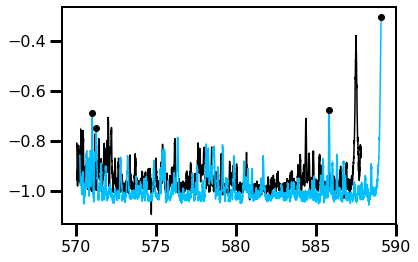

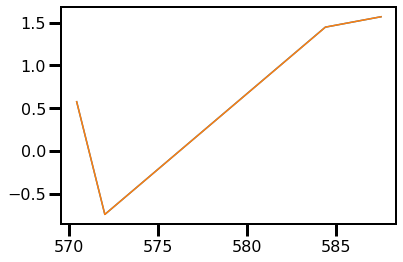

In [102]:
if key == 'halpha':
    peaks=[-0.84, -0.82]
if key == 'NaD':
    peaks=[-0.80, -0.8]
if key == 'Li':
    peaks=[-0.875, -0.86]
if key == 'mgb2':
    peaks=[-0.5,-0.55]
if key == 'caI':
    peaks=[-0.84,-0.87]
if key == 'caII' or key=='caIII':
    peaks = [-0.8,-0.8]
if key == 'FeII':
    peaks=[-0.75, -0.75]
#if key == 'HeI':
#    peaks=[-0.68,-0.68]
if key == 'HeI':
    peaks=[-0.76, -0.76]

neww, q, wavecor, offsets = get_offsets(w, s,#*1.05, 
                                      wgrid[10][cutfront:cutend],
                                      grid[10][cutfront:cutend]*1.03,
                                      peaks=peaks)
                      # ) # Lithium
                      # )  #NaD
                      # ) #halpha

In [103]:
if key == 'caII':
    print(len(np.where(q==True)[0]), len(neww))
    add = np.where(q==True)[0][0]
    q[:add] = True
    neww = np.append(np.full(add, neww[0]),
                     neww)
    print(len(np.where(q==True)[0]), len(neww), add)
    
if key == 'caI':
    poly = np.polyfit(wavecor, offsets, deg=2)
    fit = np.poly1d(poly)
    
if key == 'mgb2':
    w2, s2 = wgrid[10][cutfront:cutend]+0.0,  grid[10][cutfront:cutend]+0.0
    
    plt.figure(figsize=(8,4))
    plt.plot(w, s, 'w')
    plt.plot(w2, s2,'k')
    search11 = [513.5, 513.8, 515.65, 516.1, 517.0, 518.8, 518.9, 519.1]
    search12 = [513.6, 513.9, 515.8, 516.25, 517.2, 518.85, 519., 519.2]
    
    search21 = [513.95, 514.3, 516.7, 517.3, 518.3, 520.50, 520.6, 520.9]
    search22 = [514.10, 514.4, 516.9, 517.5, 518.5, 520.55, 520.7, 521.0]
    
    peaks1 = np.zeros(len(search11), dtype=int)
    peaks2 = np.zeros(len(search21), dtype=int)
    mgoffset = np.zeros(len(search21))
    wavecorr = np.zeros(len(search21))
    
    for i in range(len(search21)):
        q = np.where((w>=search11[i]) & (w<=search12[i]))[0]
        peaks1[i] = q[np.argmin(s[q])]
        q = np.where((w2>=search21[i]) & (w2<=search22[i]))[0]
        peaks2[i] = q[np.argmin(s2[q])]
        mgoffset[i] = w2[peaks2[i]] - w[peaks1[i]]
        wavecorr[i] = w2[peaks2[i]]
        
    plt.plot(w[peaks1], s[peaks1], 'o')
    plt.plot(w2[peaks2], s2[peaks2], 'o')
    print(wavecorr, mgoffset)
        
    o_interp = interp1d(wavecorr, mgoffset)
    poly = np.polyfit(wavecorr, mgoffset, deg=2)
    fit = np.poly1d(poly)

In [104]:
plt.rcParams['font.size'] = 16

NameError: name 'offsetw' is not defined

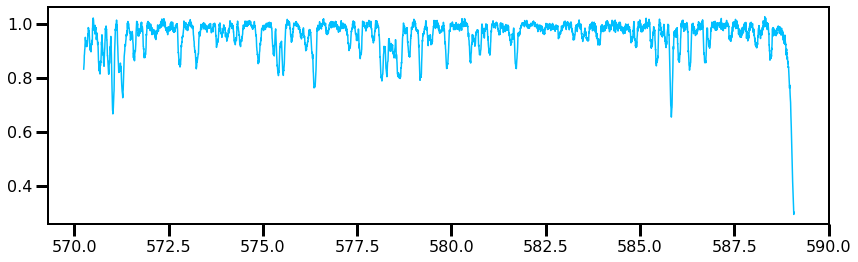

In [105]:
plt.figure(figsize=(14,4))

plt.plot(wgrid[10][cutfront:cutend], 
         grid[10][cutfront:cutend],
         'deepskyblue', label='OPERA')

start, stop = wgrid[10][cutfront:cutend][0], wgrid[10][cutfront:cutend][-1]


w = wavedict[key][10][cutfront_me:cutend_me]+0.0
s = specdict[key][10][cutfront_me:cutend_me]+0.0

interp = interp1d(wgrid[10][cutfront:cutend], grid[10][cutfront:cutend])
interpwave = np.logspace(np.log10(wgrid[10][cutfront:cutend][1]),
                         np.log10(wgrid[10][cutfront:cutend][-2]), 
                         len(offsetw))
#interpwave = np.flip(interpwave) + 0.0


if key == 'mgb2' or key == 'caI':
    neww = fit(w)
    q = np.full(len(w), True)
#    plt.plot(w+neww, s, 'k', lw=2)
#else:
plt.plot(w[q]+neww, s[q], 'k', lw=2, label='ours')
    
plt.xlim(lines[lines['line']==key]['rest_wavelength']-1.5,
         lines[lines['line']==key]['rest_wavelength']+1.5)
#plt.ylim(0.8,1.04)
#plt.xlim(840,851)
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Normalized Flux')

#plt.savefig('/Users/arcticfox/Desktop/calcium_compare.png')

In [106]:
newwave = np.zeros((len(specdict[key]), 
                    len(wavedict[key][0][cutfront_me:cutend_me][q])))
newspec = np.zeros((len(specdict[key]), 
                    len(wavedict[key][0][cutfront_me:cutend_me][q])))

(586.0, 588.0)

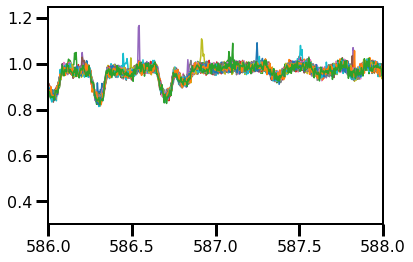

In [107]:
for i in range(len(specdict[key])):
    if key == 'halpha':
        offset=-0.01
    elif key == 'caII' or key =='caIII' or key == 'FeII':
        offset = 0.0
    elif key == 'caI':
        offset = -0.5
    elif key == 'NaD':
        offset = -0.075
    elif key == 'Li':
        offset = +0.14
    elif key == 'mgb2':
        offset = 0.25
    else:
        offset=0
        
    plt.plot(wavedict[key][i][cutfront_me:cutend_me][q]+neww+offset,
             specdict[key][i][cutfront_me:cutend_me][q])

    newwave[i] = wavedict[key][i][cutfront_me:cutend_me][q]+neww+offset
    newspec[i] = specdict[key][i][cutfront_me:cutend_me][q]
#plt.xlim(lines[lines['line']==key]['rest_wavelength']-1.5,
#         lines[lines['line']==key]['rest_wavelength']+1.5)
plt.xlim(586,588)

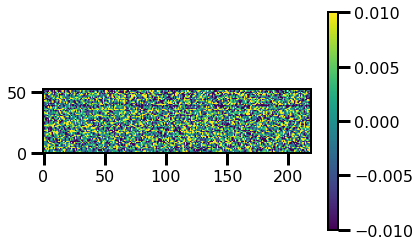

In [108]:
q = ( (newwave[0]>=lines[lines['line']==key]['rest_wavelength']-0.5) & 
     (newwave[0]<=lines[lines['line']==key]['rest_wavelength']+0.5) )
plt.imshow(newspec[:,q]-np.nanmedian(newspec[:,q], axis=0), origin='lower',
           vmin=-0.01, vmax=0.01)
plt.colorbar()

In [109]:
datadir = '/Users/arcticfox/Downloads/gemini_data'
np.save(os.path.join(datadir, 'corrected_{}_adjusted_wave.npy'.format(key)),
        newwave)                
np.save(os.path.join(datadir, 'corrected_{}_adjusted_spec.npy'.format(key)),
        newspec)

## Re add back in

In [113]:
newwaves = np.sort([os.path.join(datadir, i) for i in os.listdir(datadir) if
                    '_adjusted_wave' in i])
newspecs = np.sort([os.path.join(datadir, i) for i in os.listdir(datadir) if
                    '_adjusted_spec' in i])

In [114]:
interpo = np.load(os.path.join(datadir, 'interpolated_orders.npy'))
interps = np.load(os.path.join(datadir, 'interpolated_spectra.npy'))
interpw = np.load(os.path.join(datadir, 'interpolated_wavelengths.npy'))

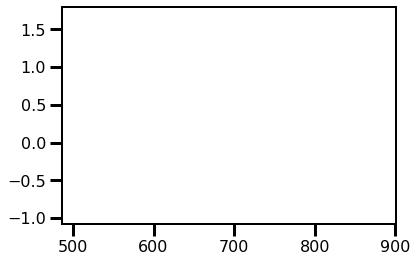

In [115]:
for i in range(len(newwaves)):
    w = np.load(newwaves[i])
    s = np.load(newspecs[i])

    key = newwaves[i].split('_')[2]
    order = lines[lines['line']==key]['index']

    neww = np.linspace(w[0][0], w[0][-1], len(interpo[0][order][0]))

    for j in range(len(w)):
        interp = interp1d(w[j], s[j])
        plt.plot(neww, interp(neww), 'w')
        interpw[j][order] = neww + 0.0
        interps[j][order] = interp(neww) + 0.0

In [116]:
np.save(os.path.join(datadir, 'interpolated_spectra_new.npy'), interps)
np.save(os.path.join(datadir, 'interpolated_wavelengths_new.npy'), interpw)